In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
%matplotlib inline

from numba import jit, njit, prange

import mpmath
from mpmath import mpf, mpc


In [2]:
n = 10
np.random.randn(n) @ np.random.randn(n)

2.8603112702645412

In [3]:
%load_ext autoreload
%autoreload 2
from mandel_algorithms import *

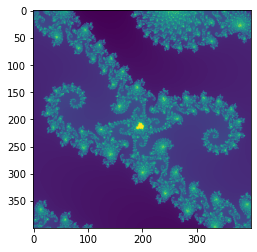

In [4]:

'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116
xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
nmax = 1000

xarr, yarr = meshgrid(xarr, yarr)

mandel = mandelbrot(xarr, yarr, nmax)
mandel

plt.imshow(np.log(mandel.T[::-1]))

In [5]:
## Autoencoder
import torch
from torch import nn
from utils import *

class Encoder(nn.Module):
    def __init__(self, n=64, h=512):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.actv = nn.ELU(0.1)
        
        self.conv0 = nn.Conv2d(1, n, 3, padding=1)
        
        self.conv1 = nn.Conv2d(n, n, 3, padding=1)
        self.conv2 = nn.Conv2d(n, 2*n, 3, padding=1)
        
        self.conv3 = nn.Conv2d(2*n, 2*n, 3, padding=1)
        self.conv4 = nn.Conv2d(2*n, 3*n, 3, padding=1)
        
        self.conv5 = nn.Conv2d(3*n, 3*n, 3, padding=1)
        self.conv6 = nn.Conv2d(3*n, 3*n, 3, padding=1)
        
        self.fc = nn.Linear(16*16*3*n, h)
        
        self.cuda()
        
    def forward(self, x):
        actv = self.actv
        
        x = x.reshape(-1, 1, 64, 64)
        
        x = actv(self.conv0(x))
        
        x = actv(self.conv1(x))
        x = actv(self.conv2(x))
        self.xc2 = x
        x = self.maxpool(x)
        
        x = actv(self.conv3(x))
        x = actv(self.conv4(x))
        self.xc4 = x
        x = self.maxpool(x)
        
        x = actv(self.conv5(x))
        x = actv(self.conv6(x))
        self.xc6 = x
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        
        return x
        
        
class Decoder(nn.Module):
    def __init__(self, n=64, h=512):
        super().__init__()
        
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.actv = nn.ELU()
        
        self.fc = nn.Linear(h, 16*16*n)
        
        self.conv1 = nn.Conv2d(n, n, 3, padding=1)
        self.conv2 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv3 = nn.Conv2d(2*n, n, 3, padding=1)
        self.conv4 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv5 = nn.Conv2d(2*n, n, 3, padding=1)
        self.conv6 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv7 = nn.Conv2d(n, 1, 3, padding=1)
        
        self.cuda()
        
    def forward(self, x):
        
        actv = self.actv
        
        h0 = actv(self.fc(x))
        h0 = h0.reshape(x.size(0), -1, 16, 16)
        
        x = h0
        x = actv(self.conv1(x))
        x = actv(self.conv2(x))
        x = self.upsample(x)
        
        h0 = self.upsample(h0)
        x = torch.cat((x, h0), 1)
        x = actv(self.conv3(x))
        x = actv(self.conv4(x))
        x = self.upsample(x)
        
        h0 = self.upsample(h0)
        x = torch.cat((x, h0), 1)
        x = actv(self.conv5(x))
        x = actv(self.conv6(x))
        
        x = self.conv7(x)
        
        x = x.reshape(-1, 64, 64)
        
        return x
        
class Autoencoder(nn.Module):
    def __init__(self, n=64):
        super().__init__()
        self.enc = Encoder(n)
        self.dec = Decoder(n)
    def forward(self, x, eps=0.):
        eps = x + eps*torch.rand_like(x)
        return self.dec(self.enc(x))
    

net = Autoencoder()
net.iters = 0
net.optim = torch.optim.Adam(lr=0.001, betas=(0.9, 0.999), params=net.parameters())

In [6]:
def _cost(imgs):
    if len(imgs)==0: return []
    t = imgs
    t = (t - t.mean((1,2), keepdims=True)) / (t.std((1,2), keepdims=True)+1e-2)
    t = t.clip(-3, 3)
    t = np2t(t)
    p = net(t)
    c = t2np(l1l2(p,t)).mean((1,2))
    return c

def cost(imgs):
    if len(imgs) > bnum:
        return np.concatenate([ _cost(imgs[bnum*i:bnum*(i+1)]) for i in range(int(len(imgs)//bnum)+1) ])
    else:
        return _cost(imgs)
    
    

'''
def _cost(hr):
    if len(hr)==0: return []
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    c = abs(sr-hr).mean((1,2,3))
    return t2np(c)

def cost(imgs):
    if len(imgs) > bnum:
        return np.concatenate([ _cost(imgs[bnum*i:bnum*(i+1)]) for i in range(int(len(imgs)//bnum)+1) ])
    else:
        return _cost(imgs)''';

In [7]:
bnum = 64

def trainstep(indf=None):
    if type(indf) is type(None):
        indf = lambda: np.random.randint(len(replaybuffer), size=bnum)
    net.iters += 1
    net.zero_grad()
    #t = replaybuffer[indf()]
    t = np.asarray([replaybuffer[i] for i in indf()])
    t = (t - t.mean((1,2), keepdims=True)) / (t.std((1,2), keepdims=True)+1e-2)
    t = t.clip(-3, 3)
    t = np2t(augment8(t))
    p = net(t, eps=2)

    loss = l1l2(p,t).mean()
    loss.backward()
    net.optim.step()
    
    
    return loss.item()


'''
bnum = 64

def trainstep(indf=None):
    if type(indf) is type(None):
        indf = lambda: np.random.randint(len(replaybuffer), size=bnum)
    net.iters += 1
    
    net.zero_grad()
    hr = np.asarray([replaybuffer[i] for i in indf()])
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    loss = abs(sr-hr).mean()

    loss.backward()
    net.optim.step()
    
    return loss.item()''';

In [4]:

import torch
from torch import nn
from utils import *
actv = nn.functional.relu
actv = nn.functional.gelu

from torch.nn.functional import interpolate

class EDSR(nn.Module):
    def __init__(self, channels=64, inter=5): ####### war 15
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, 5, padding=2, padding_mode='reflect')
        # EDSR Variant
        self.convblocks1 = nn.ModuleList([nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)])
        self.convblocks2 = nn.ModuleList([nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)])
        #self.convblocks1 = nn.ModuleList([nn.Conv2d(channels, channels//3*2, 3, padding=1, padding_mode='reflect') for k in range(inter)]) # GLU 1x
        #self.convblocks2 = nn.ModuleList([nn.Conv2d(channels//3*1, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)]) # GLU 1x
        
        self.conv_post = nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect')
        self.upconv1 = nn.Conv2d(channels, 4*channels, 3, padding=1, padding_mode='reflect')
        self.upconv2 = nn.Conv2d(channels, 4*channels, 3, padding=1, padding_mode='reflect')
        self.convlast = nn.Conv2d(channels, 1, 9, padding=4, padding_mode='reflect')
        
        self.cuda()
        self.epoch = 0
        self.iters = 0
        self.trainloss = []
        self.valloss = []
        
    @staticmethod
    def pixelshuffle(x, f=2):
        'Pixel shuffle im Format NCHW'
        n, c, h, w = x.shape
        x = x.view(n, c//f**2, f, f, h, w)
        x = x.permute(0, 1, 4, 2, 5, 3)
        #x = x.permute(0, 1, 2, 4, 3, 5)
        x = x.reshape(n, c//f**2, f*h, f*w)
        return x
            
    def forward(self, x):
        # NHWC zu NCHW
        x = x.permute([0, 3, 1, 2])
        x_bilin = interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        x -= 0.5
        x_res = x = actv(self.conv1(x))
        
        for conv1, conv2 in zip(self.convblocks1, self.convblocks2):
            x = x + 0.1 * conv2(actv(conv1(x)))
            #x = x + 0.1 * conv2(glu(conv1(x)))
        x = x_res + self.conv_post(x)
        
        x = self.pixelshuffle(self.upconv1(x))
       ## x = self.pixelshuffle(self.upconv2(x))
        
        x = self.convlast(x)
        #x = self.convlast(x) + 0.5
        x = doubleleaky(x, alpha=0.1)
        
        # restore NHWC-Format
        x = x.permute([0, 2, 3, 1])
        return x
    
    def eval(self, x, mbs=2):
        batches = [ x[mbs*i:mbs*(i+1)] for i in range(len(x)//mbs)]
        return torch.cat([self(b) for b in batches])
    
net = EDSR()
net.iters = 0
net.optim = torch.optim.Adam(lr=0.001, betas=(0.9, 0.999), params=net.parameters())

In [11]:


def _cost(hr):
    if len(hr)==0: return []
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    c = abs(sr-hr).mean((1,2,3))
    return t2np(c)

def cost(imgs):
    if len(imgs) > bnum:
        return np.concatenate([ _cost(imgs[bnum*i:bnum*(i+1)]) for i in range(int(len(imgs)//bnum)+1) ])
    else:
        return _cost(imgs)

In [12]:
bnum = 64

def trainstep(indf=None):
    if type(indf) is type(None):
        indf = lambda: np.random.randint(len(replaybuffer), size=bnum)
    net.iters += 1
    
    net.zero_grad()
    hr = np.asarray([replaybuffer[i] for i in indf()])
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    loss = abs(sr-hr).mean()

    loss.backward()
    net.optim.step()
    
    return loss.item()

  0%|          | 0/100 [00:00<?, ?it/s]

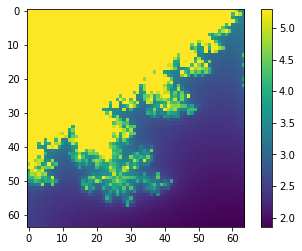

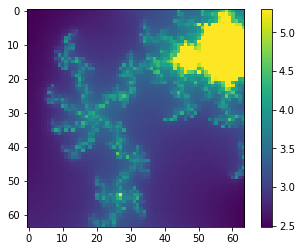

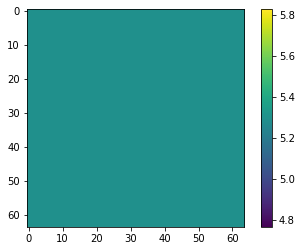

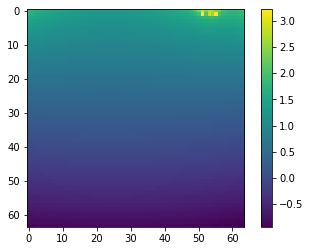

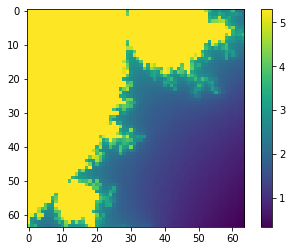

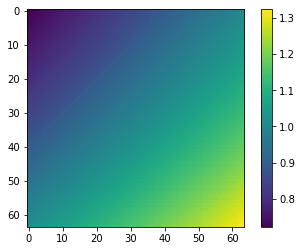

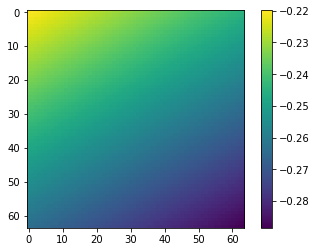

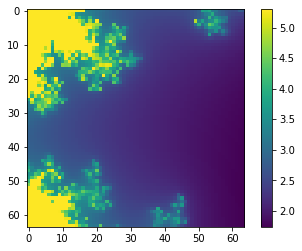

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


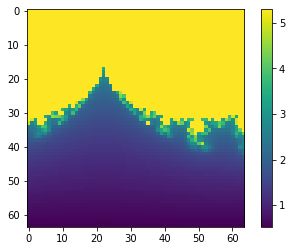

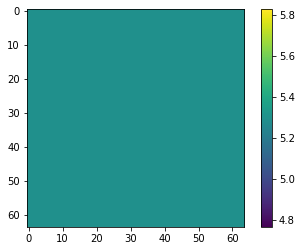

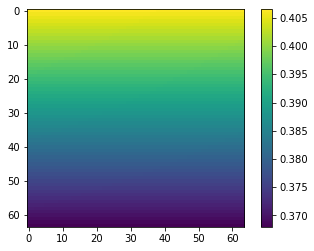

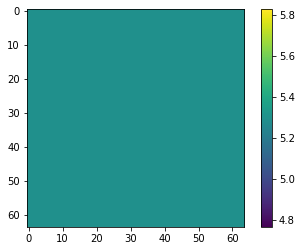

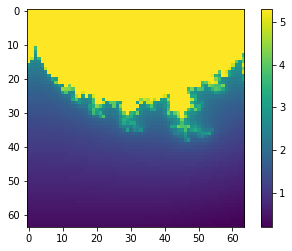

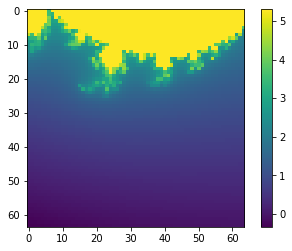

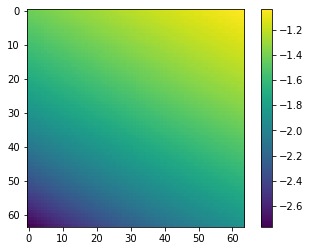

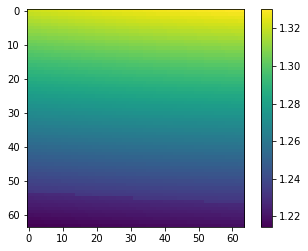

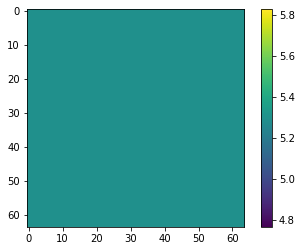

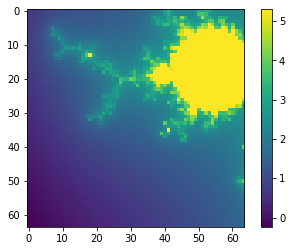

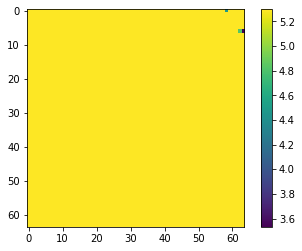

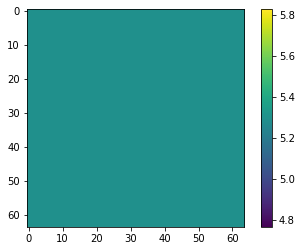

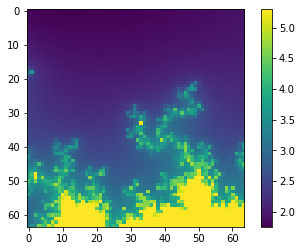

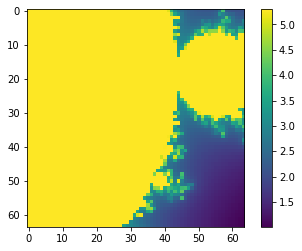

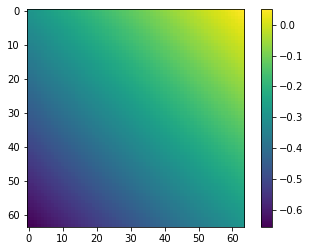

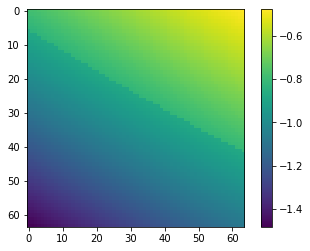

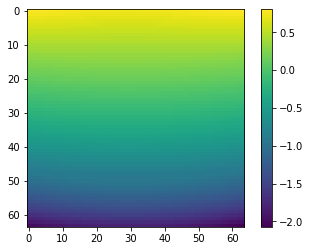

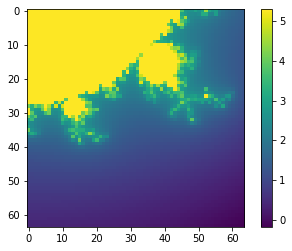

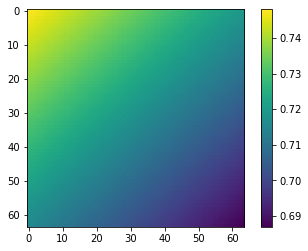

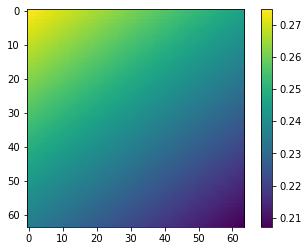

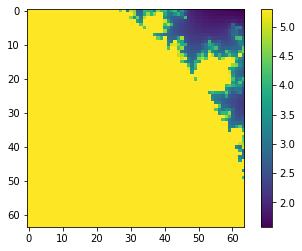

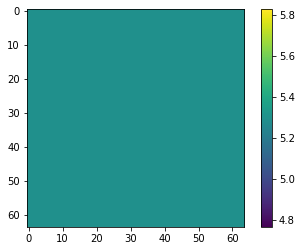

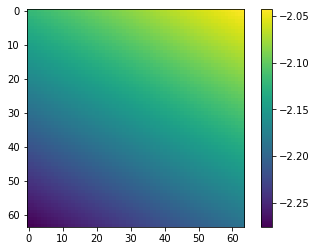

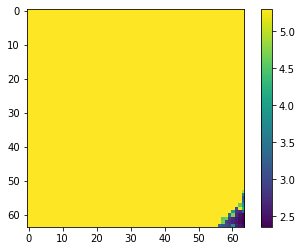

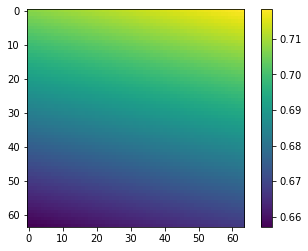

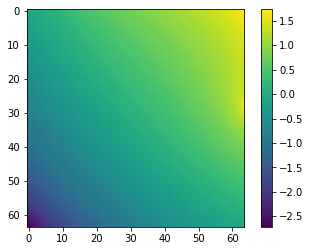

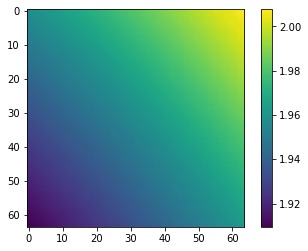

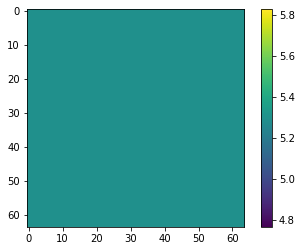

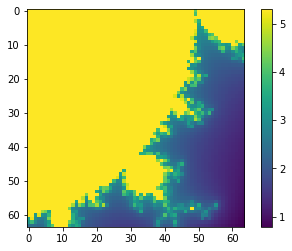

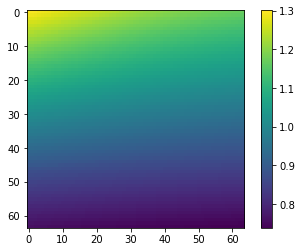

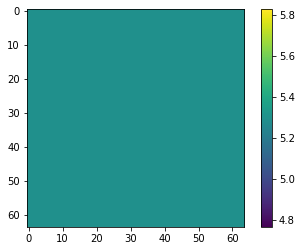

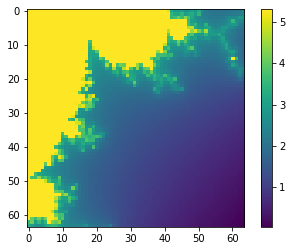

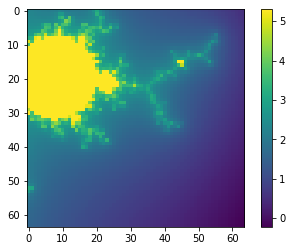

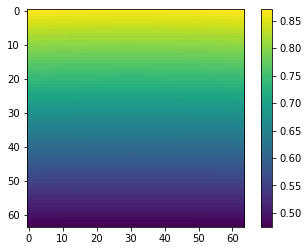

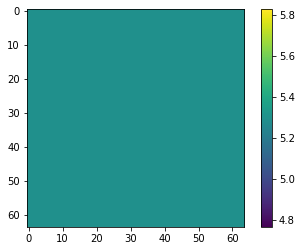

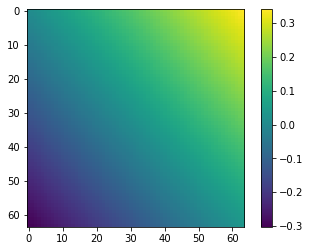

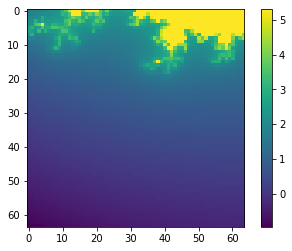

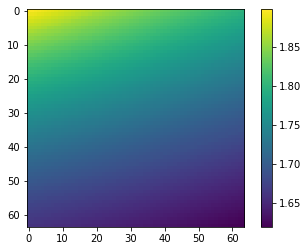

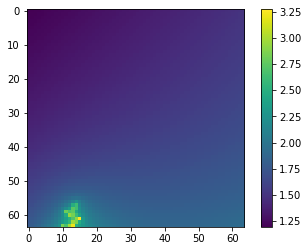

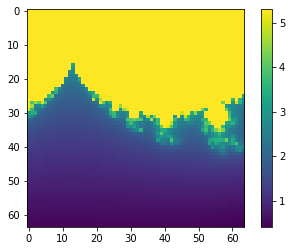

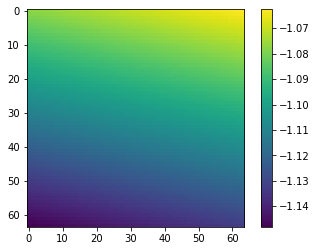

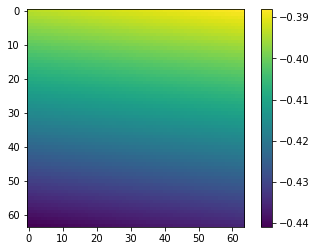

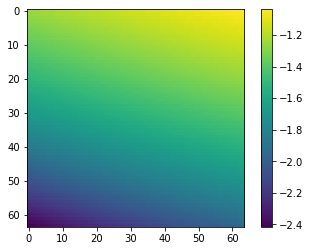

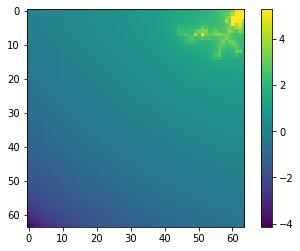

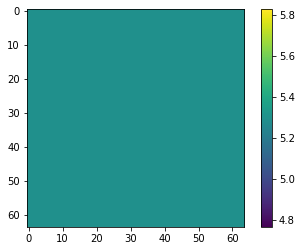

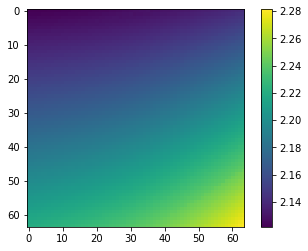

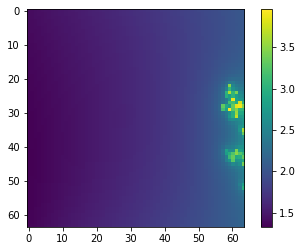

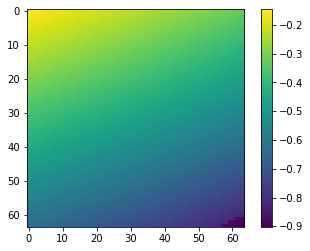

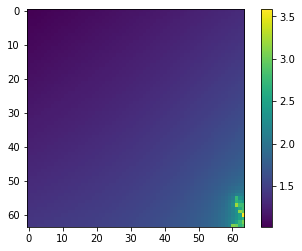

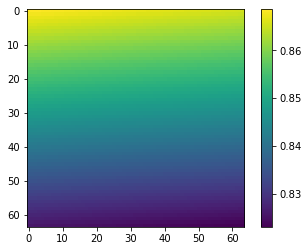

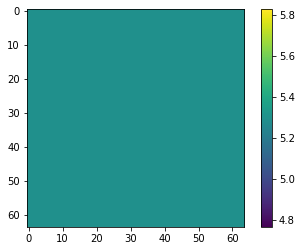

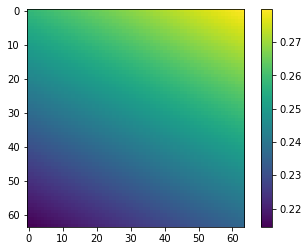

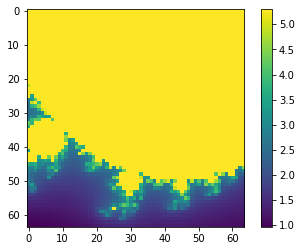

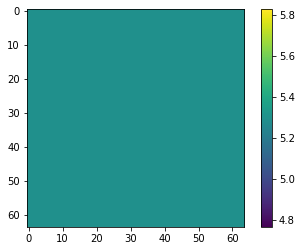

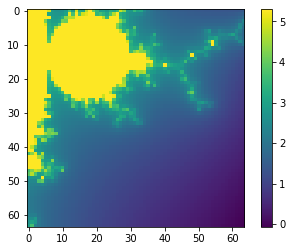

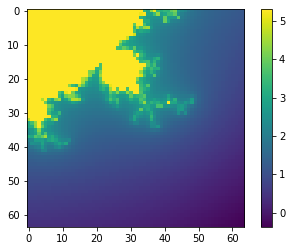

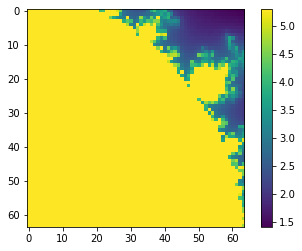

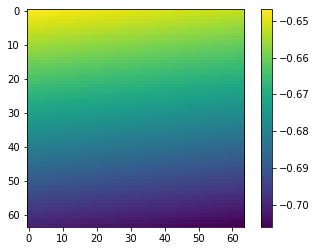

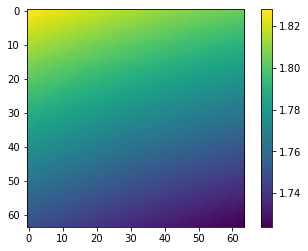

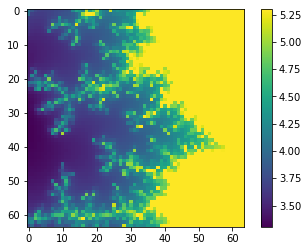

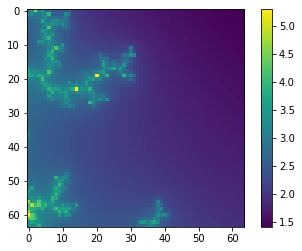

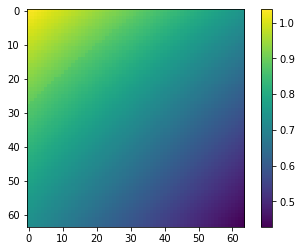

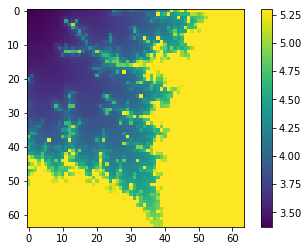

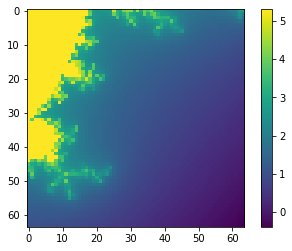

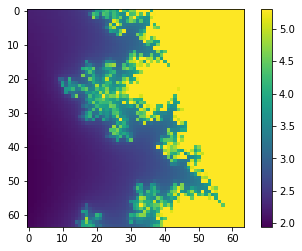

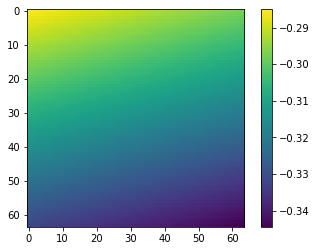

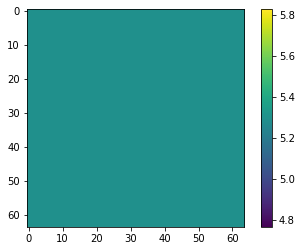

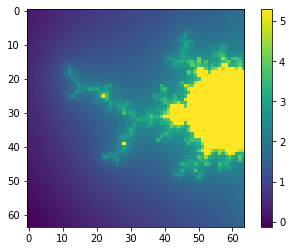

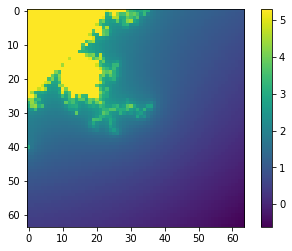

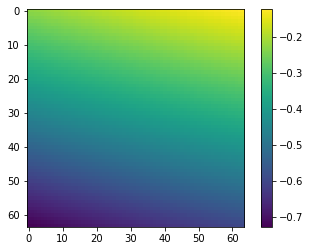

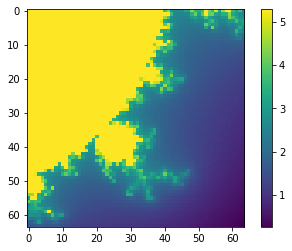

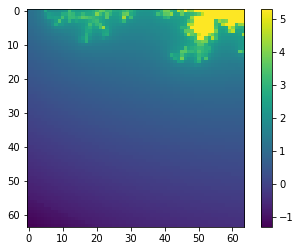

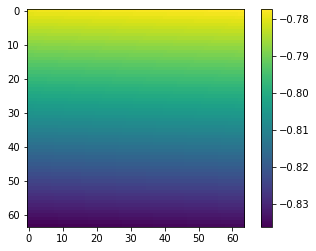

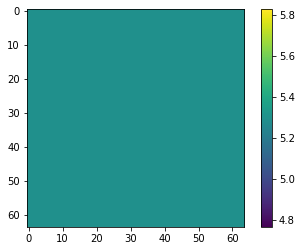

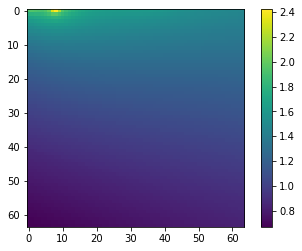

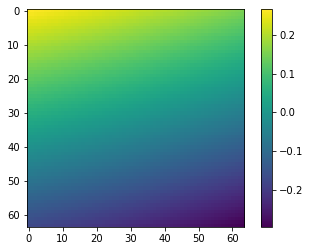

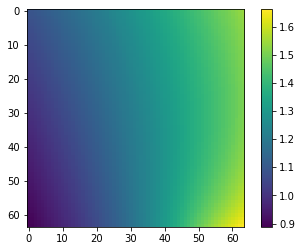

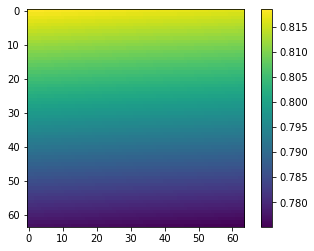

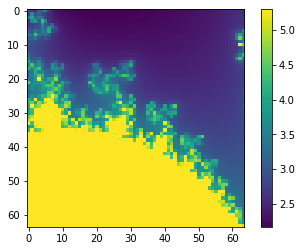

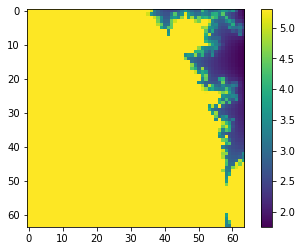

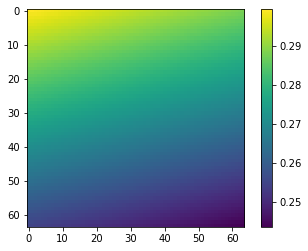

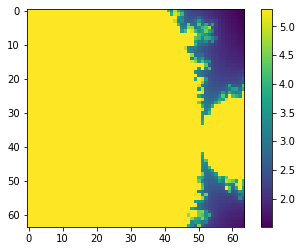

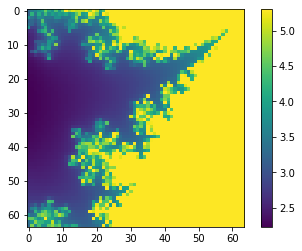

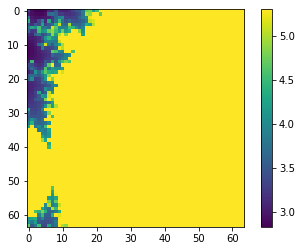

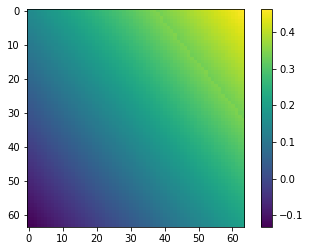

In [8]:
# Einige Bilder in den replaybuffer packen und schon mal das Netzwerk vortrainieren

replaybuffer = []
np.random.seed(0)
for _ in trange(100):
    mid = np.random.rand()*1.5-0.5, np.random.rand()*2-1
    width = np.random.choice([0.5, 0.1, 0.01])
    xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 64)
    yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 64)
    nmax = 200
    xarr, yarr = meshgrid(xarr, yarr)
    
    mandel = mandelbrot(xarr, yarr, nmax)
    mandel = np.log(mandel)
    if np.any(np.isnan(mandel)): continue
    plt.imshow(mandel)
    plt.colorbar()
    plt.show()
    replaybuffer.append(mandel)
    
#replaybuffer = np.asarray(replaybuffer)

In [9]:
for _ in trange(25):
    print(trainstep())

  0%|          | 0/100 [00:00<?, ?it/s]

0.7437562942504883
0.8317365646362305
0.758425235748291
0.6013840436935425
0.3585171103477478
0.4693433344364166
0.6498368978500366
0.5368772149085999
0.6032412052154541
0.487649142742157
0.45042404532432556
0.3716069161891937
0.2618749439716339
0.36460310220718384
0.32882553339004517
0.2574319839477539
0.2143564671278
0.20374536514282227
0.2596741318702698
0.20774458348751068
0.23703590035438538
0.19693440198898315
0.1933744251728058
0.2583140730857849
0.1702115535736084
0.24731722474098206
0.20781496167182922


KeyboardInterrupt: 

In [11]:
cs = _cost(np.asarray(replaybuffer[:]))

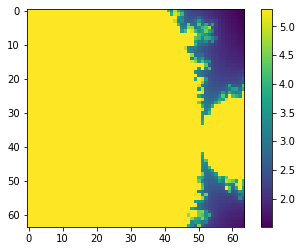

0.74124146


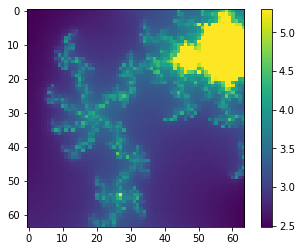

0.71012664


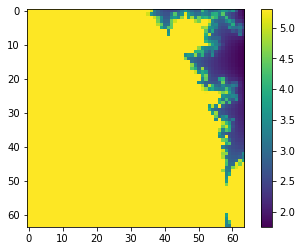

0.6968541


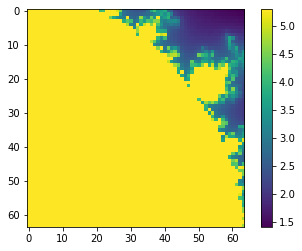

0.67177284


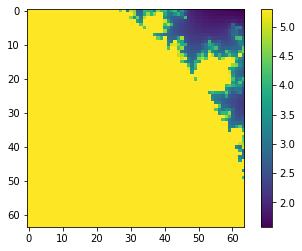

0.6645146


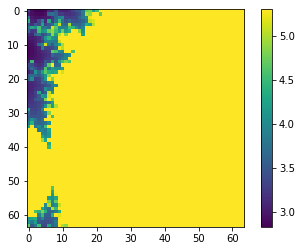

0.6232591


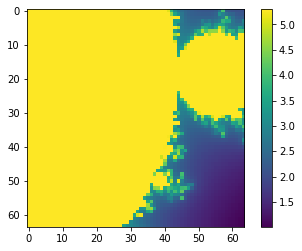

0.6188053


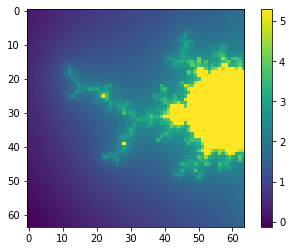

0.55611026


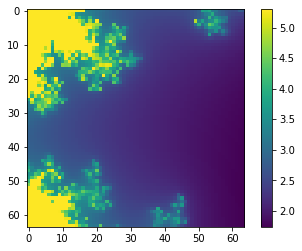

0.51350576


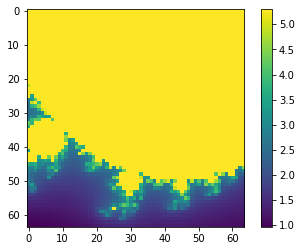

0.4820736


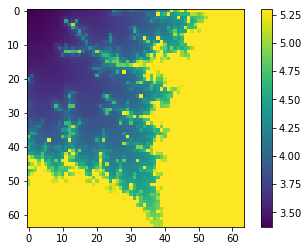

0.48089772


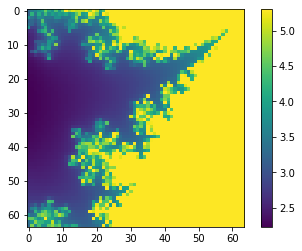

0.4752612


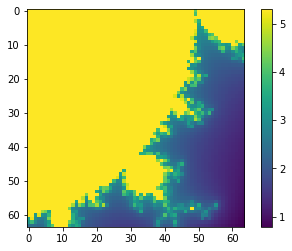

0.4734919


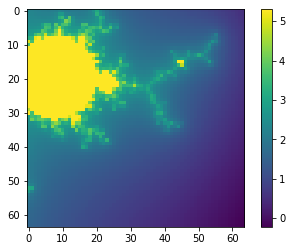

0.42052835


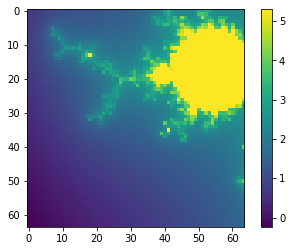

0.38282907


KeyboardInterrupt: 

In [12]:
# Veranschaulichung der Curiousitybewertung

for i in np.argsort(-cs)[:]:
    plt.imshow(replaybuffer[i])
    plt.colorbar()
    plt.show()
    print(cs[i])

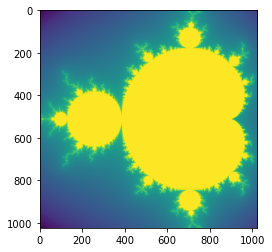

In [13]:

xarr = np.linspace(-1.5, 0.5, 1024)
yarr = np.linspace(-1, 1, 1024)
nmax = 200
xarr, yarr = meshgrid(xarr, yarr)

mandel = mandelbrot(xarr, yarr, nmax)
mandel = np.log(mandel)

plt.imshow(mandel.T[::-1])

In [14]:
parts = mandel.reshape(16, 64, 16, 64)
parts = parts.transpose(0, 2, 1, 3).reshape((-1, 64, 64))

c = [_cost(parts[i:i+1]) for i in range(len(parts))]
c = np.asarray(c).reshape(16, 16)

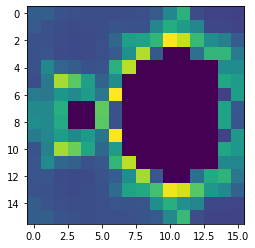

In [15]:
plt.imshow(c.T[::-1])

In [17]:
nrec = 24

def recursion(xmin, xmax, ymin, ymax, n=0, f=4, key=''):
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    #nmax = 2000
    nmax = 8000
    xarr, yarr = meshgrid(xarr, yarr)

    if n >= nrec: return
    
    if not key in visited:
        mandel = mandelbrot_cuda(xarr, yarr, nmax)
        #mandel = mandel_byreference_cuda(xarr, yarr, nmax)
        mandel = np.log(mandel).astype('float16')


        visited[key] = len(gallery_hr)
        gallery_hr.append(mandel)
        depths.append(n)
    else:
        mandel = gallery_hr[visited[key]]
       
    parts = mandel.reshape(f, 64, f, 64)
    parts = parts.transpose(0, 2, 1, 3).reshape((-1, 64, 64))
    c = _cost(parts)

    i = np.argsort(c)[(-1 if np.random.rand()>(.3) else -2)]  # sometimes take the second best to avoid repititions!
    i = np.argsort(c)[np.random.choice([-1, -2, -3, -4], p=(0.4, 0.3, 0.2, 0.1))]
    ##i = np.random.randint(f**2)

    w = xmax-xmin
    xmin = xmin + w/f * (i//f)
    xmax = xmin+w/f

    h = ymax-ymin
    ymin = ymin + h/f * (i%f)
    ymax = ymin+h/f

    key += str(i)+';'
    if not key in visited:
        gallery.append(parts[i])
        rects.append((xmin, xmax, ymin, ymax))
    
    ##del mandel, parts
    recursion(xmin, xmax, ymin, ymax, n+1, f, key)
    
    
n0 = 64
def render_mandel(rect, nmax=2000, n=n0, centered=True):
    xmin, xmax, ymin, ymax = rect
    xarr = np.linspace(xmin, xmax, n)
    yarr = np.linspace(ymin, ymax, n)
    if centered:
        xarr = np.linspace(xmin, xmax, n, endpoint=False) + (xmax-xmin)/n
        yarr = np.linspace(ymin, ymax, n, endpoint=False) + (ymax-ymin)/n
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = mandelbrot_cuda(xarr, yarr, nmax)
    mandel = np.log(mandel)
    mandel[np.isnan(mandel)] = 0
    return mandel
    
    
import heapq
import seaborn as sns

def init_leaf(xmin, xmax, ymin, ymax):
    global leafs_img, leafs_rect, leafs_pausetil
    mandel = render_mandel((xmin, xmax, ymin, ymax), 50)
    leafs_img = mandel[None]
    leafs_rect = [(xmin, xmax, ymin, ymax)]
    leafs_pausetil = [0]
    
ncalls=0
def sdfds(f=2):
    # für leaf bilder im array die costs auswerten
    global leafs_img, leafs_rect, leafs_pausetil, ncalls
    ncalls += 1
    
    c = cost(leafs_img)
    ##c += np.log2(np.array([ xmax-xmin for xmin, xmax, _, _, in leafs_rect ])) \
    ##        * np.random.choice((1/20, 1/40, 0))
    c += - np.max(np.array(leafs_pausetil)-ncalls, 0)
    
    # finde best 10 werte und tue sie in max-queue
    largest = heapq.nlargest(10, range(len(leafs_img)), c.__getitem__)
    
    ## TEST
    c /= c.max()
    if ncalls%10==0: sns.distplot(c); plt.show()
    p = np.exp(c*6)
    largest = np.random.choice(range(len(c)), size=10, p=p/sum(p))
    ## END TEST
    
    # iteration um bilder zu finden
    for i in largest:
        
        # bild in hd rendern(?)
        mandel = render_mandel(leafs_rect[i], n=f*n0)
        rects.append(leafs_rect[i])
        gallery.append(leafs_img[i].astype('float16'))
        gallery_hr.append(mandel.astype('float16'))
        
        
        # bild teilen und werte berechnen, dann in den array, dann in die queue
        new = mandel.reshape((f, n0, f, n0)).transpose((0, 2, 1, 3)).reshape((-1, n0, n0)).astype('float16')
        leafs_img = np.concatenate((leafs_img, new))
        
        xmin, xmax, ymin, ymax = leafs_rect[i]
        w, h = (xmax-xmin)/f, (ymax-ymin)/f
        
        leafs_rect += [(xmin+j*w, xmin+(j+1)*w, ymin+k*w, ymin+(k+1)*w) for j in range(f) for k in range(f)]
        leafs_pausetil += f**2 * [ncalls + 50]
        
    # aufräumen
    for i in sorted(largest, reverse=True):
        leafs_img[i:-1] = leafs_img[i+1:]
        leafs_img = leafs_img[:-1]
        leafs_rect.pop(i)
        leafs_pausetil.pop(i)
        

In [19]:
init_leaf(-1.5, .5, 0, 2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


In [20]:
bnum = 64
gallery = []
gallery_hr = []
depths = []
costs = []
rects = []
visited = dict()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


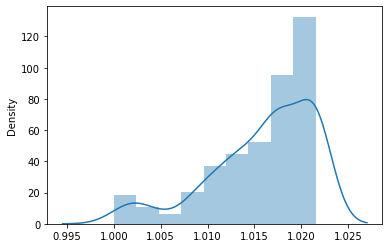

100 100


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


IndexError: list index out of range

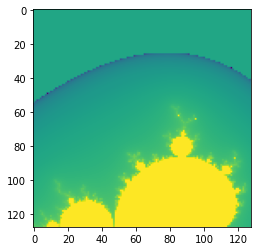

In [21]:
import pickle

last = len(gallery)
last_hr = len(gallery_hr)
for k in range(99999999999):
    for _ in range(10): ##10!!!
        ##sdfds()
        recursion(-1.5, .5, -1, 1, f=4)
    #print(len(gallery), len(leafs_img), len(leafs_rect))
    print(len(gallery), len(gallery_hr))

    #for im in gallery_hr[last::5]:
    for k in range(last_hr, len(gallery_hr), 1):
        im = gallery_hr[k]
        plt.imshow(im.T[::-1].astype('float64'))
        plt.title(depths[k])
        plt.show()
    last_hr = len(gallery_hr)
        
    #new = np.stack(gallery[last:])
    #replaybuffer = np.concatenate((new, replaybuffer))
    new = gallery[last:]
    replaybuffer = gallery[last:]+replaybuffer
    print('rb:', len(replaybuffer))
    last = len(gallery)
    
    for _ in range(100):
        p1 = np.exp(-1/500*np.arange(len(replaybuffer)))
        p2 = np.exp(-1/200000*np.arange(len(replaybuffer)))
        indf = lambda: np.concatenate((np.random.choice(range(len(new)), 16),
                                      np.random.choice(range(len(replaybuffer)), bnum//2, p=p1/sum(p1)),
                                      np.random.choice(range(len(replaybuffer)), bnum//2-16, p=p2/sum(p2)),))
        l = trainstep(indf)
        print('Loss = ', l)
    
    #if k%50 == 0:
    #    with open('F:/$Daten/mandelbrot_gallery_both.pkl', 'wb') as f:
    #        pickle.dump((rects, gallery, gallery_hr), f)

In [ ]:
with open('F:/$Daten/mandelbrot_gallery_both.pkl', 'wb') as f:
    pickle.dump((rects, gallery, gallery_hr), f)

In [ ]:

while True:
    recursion(-1.5, .5, -1, 1, f=10)   ###### test mit höhem f, findet er feinere strukturen wie spiralen???
    
    new = np.asarray(gallery[-nrec:])
    new_hr = np.asarray(gallery_hr[-nrec:])
    for im in new_hr:
        plt.imshow(im.T[::-1])
        plt.show()
    replaybuffer = np.concatenate((new, replaybuffer))
    print('here')
    for _ in range(50):
        p1 = np.exp(-1/2000*np.arange(len(replaybuffer)))
        p2 = np.exp(-1/200000*np.arange(len(replaybuffer)))
        indf = lambda: np.concatenate((np.random.choice(range(len(new)), 16),  # at least one of the new
                                      np.random.choice(range(len(replaybuffer)), bnum//2, p=p1/sum(p1)),
                                      np.random.choice(range(len(replaybuffer)), bnum//2-16, p=p2/sum(p2)),))
        l = trainstep(indf)
        print('Loss = ', l)

In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
with open('F:\\$Daten\\mandelbrot_gallery_both.pkl', 'rb') as f:
    rects, gallery, gallery_hr = pkl.load(f)
    

In [ ]:
for r in rects[64:66]:
    f=4
    xmin, xmax, ymin, ymax = r
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    nmax = 2000
    #nmax = 4000 ###
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = mandelbrot_cuda(xarr, yarr, nmax)
    mandel = np.log(mandel)
    plt.imshow(mandel.T[::-1])
    plt.show()

In [ ]:
for r in rects[64:66]:
    f=4
    xmin, xmax, ymin, ymax = r
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    nmax = 2000 
    nmax = 8000
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = mandelbrot_cuda(xarr, yarr, nmax)
    mandel = np.log(mandel)
    plt.imshow(mandel.T[::-1])
    plt.show()

In [ ]:
for k, img in enumerate(gallery):
    plt.imsave('F:\\$Daten\\mandelbrot_gallery3_lr\\img%05d.png' % k, img)